In [299]:
# import stuff here
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

def list_data(folder):
    """
    List all available data sets in the folder
    
    """
    s3 = boto3.resource('s3')
    bucket='cp-hackathon-data'
    hackathon_data = s3.Bucket(bucket)
    keys = []
    for obj in hackathon_data.objects.filter(Prefix=folder):
        keys.append(obj.key)
    return keys
def get_data(key):
    role = get_execution_role()
    bucket='cp-hackathon-data'
    data_location = 's3://{}/{}'.format(bucket, key)
    return pd.read_csv(data_location)

In [3]:
list_data('RedCross')

['RedCross/',
 'RedCross/ovitrap_data.csv',
 'RedCross/ovitrap_data_monthly_province.csv',
 'RedCross/weather_data_monthly_province.csv']

In [128]:
mosq = get_data('RedCross/ovitrap_data_monthly_province.csv').sort_values(['adm_level', 'date'])

Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.


In [129]:
mosq['date'] = pd.to_datetime(mosq.date).dt.date

In [130]:
weather = get_data('RedCross/weather_data_monthly_province.csv')

Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.


In [131]:
weather['date'] = pd.to_datetime(weather['date']).dt.date

In [132]:
weather.rename(mapper={
    'JAXA_GPM_L3_GSMaP_v6_operational_hourlyPrecipRateGC':'jaxa_rainfall',
    'MODIS_006_MOD11A1_LST_Day_1km': 'land_surface_temperature_day',
    'MODIS_006_MYD13A1_EVI':'vegetation_index',
    'MODIS_006_MOD11A1_LST_Night_1km': 'land_surface_temperature_night',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Qair_f_tavg': 'specific_humidity',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Rainf_f_tavg': 'fldas_rainfall',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_SoilMoi00_10cm_tavg': 'soil_moisture',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_SoilTemp00_10cm_tavg': 'soil_temperature',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Tair_f_tavg': 'air_temperature',
    'NASA_FLDAS_NOAH01_C_GL_M_V001_Wind_f_tavg': 'wind_speed'
                      },
               axis=1,
               inplace=True)

# focusing on Pangasinan province

In [135]:
mosq = weather.merge(mosq, on=['adm_level', 'date'], how='left')

In [210]:
mosq.loc[mosq.count_ovi>0].corr().sort_values('mean_ovi')

,jaxa_rainfall,land_surface_temperature_day,land_surface_temperature_night,vegetation_index,specific_humidity,fldas_rainfall,soil_moisture,soil_temperature,air_temperature,wind_speed,count_ovi,mean_ovi,error_ovi,error_relative_ovi
error_relative_ovi,-0.043448,0.019026,-0.043671,-0.080227,-0.141662,-0.091112,-0.124182,-0.035116,-0.090054,-0.071487,-0.239962,-0.421641,0.517092,1.000000
land_surface_temperature_day,-0.173665,1.000000,0.600960,-0.611760,0.281040,-0.115288,-0.172629,0.758672,0.542546,-0.316798,0.020088,-0.222230,-0.141915,0.019026
soil_temperature,-0.175397,0.758672,0.837801,-0.240100,0.530694,-0.101343,-0.245466,1.000000,0.872140,-0.022720,-0.036816,-0.133356,-0.093973,-0.035116
count_ovi,-0.010166,0.020088,-0.041350,-0.075432,-0.007945,-0.018656,0.030972,-0.036816,-0.045428,-0.024778,1.000000,-0.097539,-0.250023,-0.239962
land_surface_temperature_night,-0.125168,0.600960,1.000000,-0.087791,0.652772,-0.016092,-0.029635,0.837801,0.868089,-0.003427,-0.041350,-0.058370,-0.054209,-0.043671
air_temperature,0.015681,0.542546,0.868089,0.059572,0.790790,0.147189,0.048218,0.872140,1.000000,-0.047220,-0.045428,-0.003180,-0.038749,-0.090054
jaxa_rainfall,1.000000,-0.173665,-0.125168,0.047291,0.338619,0.783256,0.477639,-0.175397,0.015681,-0.007207,-0.010166,0.038549,0.015482,-0.043448
wind_speed,-0.007207,-0.316798,-0.003427,0.074622,-0.012287,0.069932,-0.002745,-0.022720,-0.047220,1.000000,-0.024778,0.067094,0.025556,-0.071487
specific_humidity,0.338619,0.281040,0.652772,0.087972,1.000000,0.510197,0.521520,0.530694,0.790790,-0.012287,-0.007945,0.083817,-0.013353,-0.141662
fldas_rainfall,0.783256,-0.115288,-0.016092,-0.021826,0.510197,1.000000,0.625907,-0.101343,0.147189,0.069932,-0.018656,0.115017,0.023887,-0.091112


In [138]:
df = mosq.loc[(mosq.adm_level == 'Pangasinan')&(mosq.count_ovi>0)].reset_index()
df.rename(mapper={'index':'old_index'}, axis=1, inplace=True)
train = df.iloc[1:43].set_index('date')
test = df[43:53].set_index('date')

In [168]:
temp_df =  (
    mosq.loc[(mosq.adm_level == 'Pangasinan')].reset_index()
    .rename(mapper={'index':'old_index'}, axis=1)
)
empty = (
    temp_df
    .loc[temp_df.old_index == 5261]
    .set_index('date')
)

In [169]:
empty

,old_index,adm_level,jaxa_rainfall,land_surface_temperature_day,land_surface_temperature_night,vegetation_index,specific_humidity,fldas_rainfall,soil_moisture,soil_temperature,air_temperature,wind_speed,count_ovi,mean_ovi,error_ovi,error_relative_ovi
date,,,,,,,,,,,,,,,,
2016-05-01,5261,Pangasinan,0.102047,15468.959,14878.453,3744.314,0.017385,0.00008,0.294611,302.86682,301.79465,2.731993,0.0,NaN,NaN,NaN


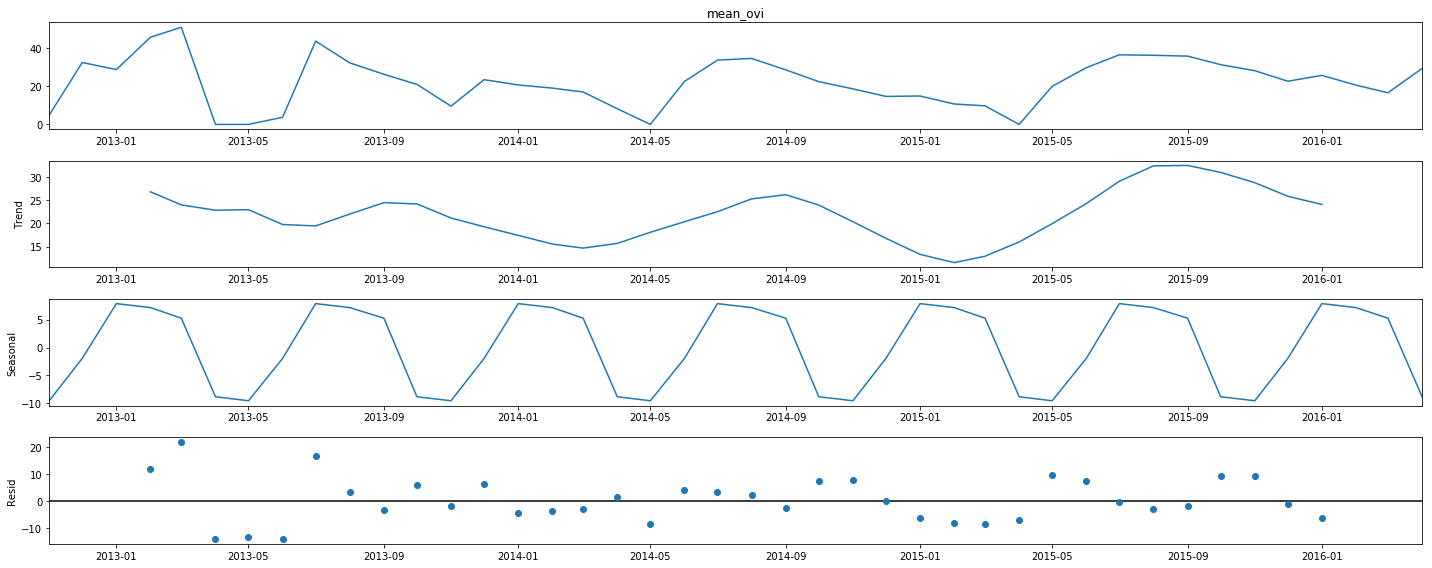

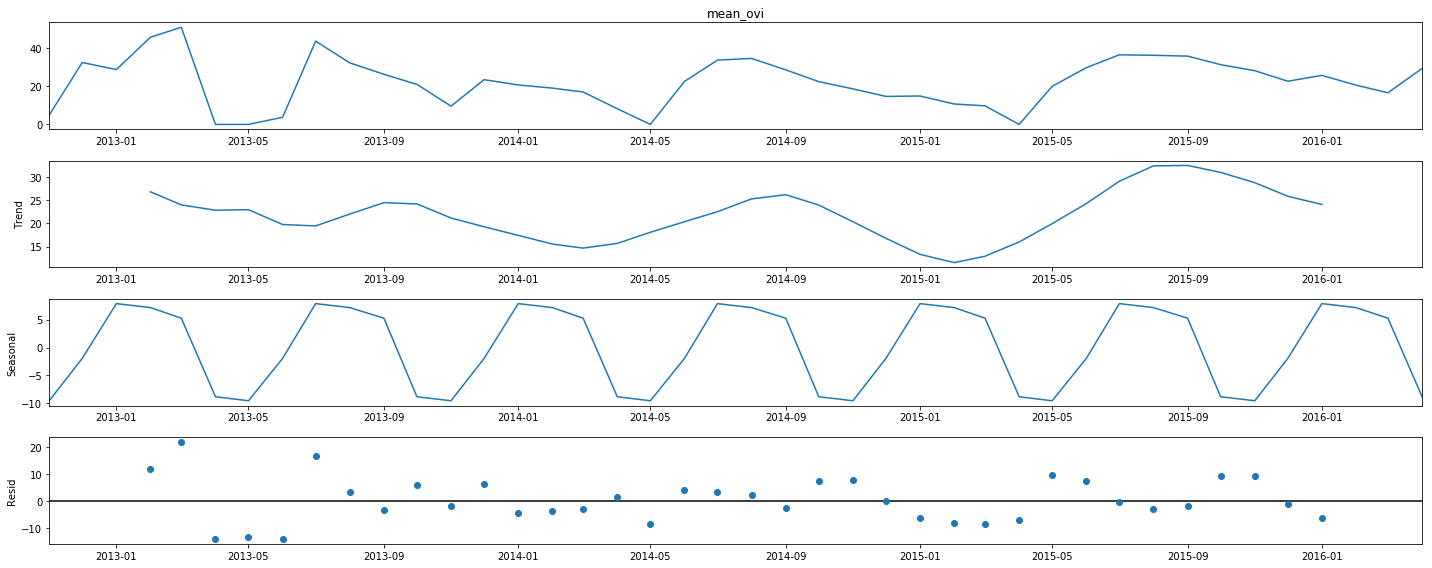

In [303]:
decomp = seasonal_decompose(train.mean_ovi, period=6)
decomp.plot()

In [219]:
sarima_model = SARIMAX(train.mean_ovi,exog = train[['vegetation_index', 'soil_moisture', 'fldas_rainfall']], order=(12,0,0), seasonal_order=(0,0,0,12))
sarima_fit = sarima_model.fit()
pred = sarima_fit.predict(exog=pd.concat([empty, test])[['vegetation_index', 'soil_moisture', 'fldas_rainfall']], start = train.index[-1]+pd.DateOffset(months=1), end = test.index[-1])

In [220]:
train['pred'] = train.mean_ovi
empty['pred'] = pred[0]
test['pred']=pred[1:]
final_df = pd.concat([train, empty, test]).sort_index()

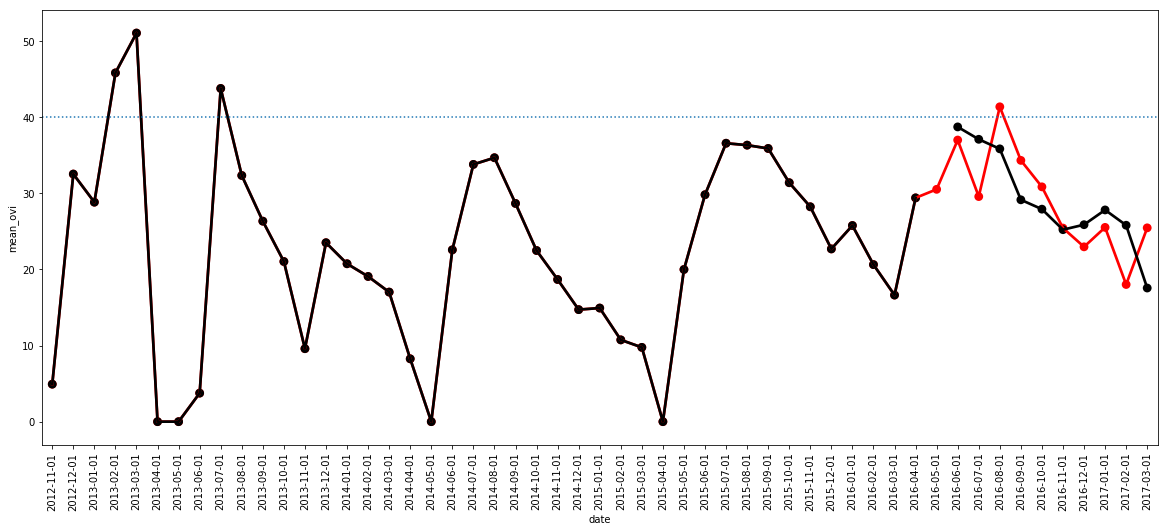

In [297]:
sns.set_context({"figure.figsize": (20, 8)})
sns.pointplot(x=final_df.index, y=final_df.pred, color='red')
sns.pointplot(x = final_df.index, y=final_df.mean_ovi, color='black')
plt.xticks(rotation=90)
plt.axhline(y=40, ls=':')

In [222]:
np.sqrt(mean_squared_error(test.pred, test.mean_ovi))

5.123682735168567

(array([1., 2., 0., 1., 1., 0., 3., 0., 0., 2.]),
 array([-7.90778773, -6.33846654, -4.76914535, -3.19982417, -1.63050298,
        -0.06118179,  1.50813939,  3.07746058,  4.64678177,  6.21610295,
         7.78542414]),
 <a list of 10 Patch objects>)

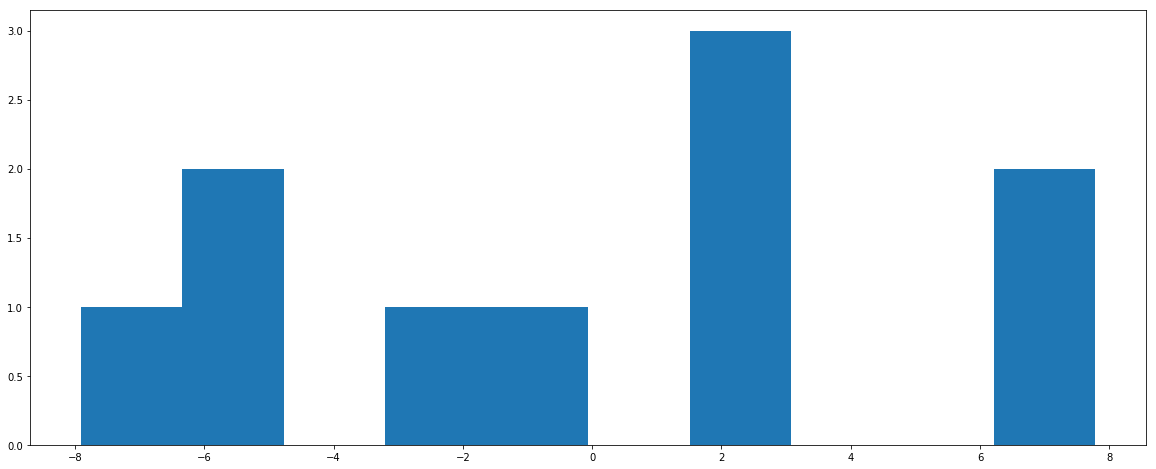

In [294]:
#plotting the residuals
res = test.mean_ovi - test.pred
plt.hist(res)

# forward chained validation

In [226]:
# impute empty value with forecasted one
cv_train = pd.concat([train, empty])
cv_train['mean_ovi'] = cv_train.pred
cv_datasets = [[cv_train, test.iloc[0]]]
cv_datasets.extend([[pd.concat([cv_train, test.iloc[0:i]]), test.iloc[i:i+1]] for i in range(1, test.shape[0])])

In [313]:
def forward_chained_validation(cv_datasets:list, columns:list):
    total_rmse=0
    for dataset in cv_datasets[1:-1]:
        df_train = dataset[0]
        df_test = dataset[1]
        sarima_model = SARIMAX(df_train.mean_ovi, exog = df_train[columns], order=(12,0,0), seasonal_order=(0,0,0,12))
        sarima_fit = sarima_model.fit()
        pred = sarima_fit.predict(exog=df_test[columns], start = df_train.index[-1]+pd.DateOffset(months=1), end = df_train.index[-1]+pd.DateOffset(months=1))
        total_rmse += np.sqrt(mean_squared_error(pred, df_test.mean_ovi))
    return(total_rmse/len(cv_datasets))

In [314]:
forward_chained_validation(cv_datasets, ['vegetation_index'])

2.5074069391611027

In [315]:
forward_chained_validation(cv_datasets, ['vegetation_index', 'soil_moisture'])

2.311366119807336

In [316]:
forward_chained_validation(cv_datasets, ['vegetation_index', 'soil_moisture', 'fldas_rainfall'])

2.6231120295460157

In [317]:
forward_chained_validation(cv_datasets, ['vegetation_index', 'soil_moisture', 'fldas_rainfall', 'specific_humidity'])

2.973771522462703

In [320]:
forward_chained_validation(cv_datasets, ['vegetation_index', 'land_surface_temperature_day'])

2.2264116619670786

In [321]:
forward_chained_validation(cv_datasets, ['vegetation_index', 'soil_moisture', 'land_surface_temperature_day'])

2.3607307756966582